In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

 98% 1.04G/1.06G [00:09<00:00, 242MB/s]
100% 1.06G/1.06G [00:09<00:00, 121MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.applications.vgg16 import VGG16

In [6]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [7]:
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [9]:
conv_base.trainable = True

set_trainable = False


# only train the block 1 layer that is true
for layer in conv_base.layers:
  if layer.name == "block5_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [70]:
# now add vgg16 model with this tranibale parameters
model = Sequential()

model.add(conv_base) # add vgg16 model
model.add(Flatten()) #flatten layer convert in to 1 d array
model.add(Dense(300,activation="elu",kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(600,activation="elu",kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(BatchNormalization())


model.add(Dense(1,activation="sigmoid"))

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 300)               9830700   
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 600)               180600    
                                                      

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img

batch_size = 64

train_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory(
    "/content/train",
    target_size = (256,256),
    batch_size = batch_size,
    class_mode = 'binary'
)

test_data = test_gen.flow_from_directory(
    "/content/test",
    target_size = (256,256),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [68]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [72]:
# now Compile the model
model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = "Adam",
    metrics = ["accuracy"]
)

In [73]:
history = model.fit_generator(train_data,epochs=6,validation_data=test_data,callbacks=[early_stopping])

Epoch 1/6
313/313 [==============================] - 378s 1s/step - loss: 0.1039 - accuracy: 0.9607 - val_loss: 0.3988 - val_accuracy: 0.8650
Epoch 2/6
313/313 [==============================] - 379s 1s/step - loss: 0.0913 - accuracy: 0.9657 - val_loss: 0.0720 - val_accuracy: 0.9704
Epoch 3/6
313/313 [==============================] - 377s 1s/step - loss: 0.0621 - accuracy: 0.9762 - val_loss: 0.1314 - val_accuracy: 0.9544
Epoch 4/6
313/313 [==============================] - 385s 1s/step - loss: 0.0524 - accuracy: 0.9805 - val_loss: 0.1049 - val_accuracy: 0.9652
Epoch 5/6
313/313 [==============================] - 385s 1s/step - loss: 0.0458 - accuracy: 0.9829 - val_loss: 0.1381 - val_accuracy: 0.9574
Epoch 6/6
313/313 [==============================] - 383s 1s/step - loss: 0.0439 - accuracy: 0.9841 - val_loss: 0.0869 - val_accuracy: 0.9716


In [74]:
import pandas as pd
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.103947,0.96075,0.398754,0.8650
1,0.091320,0.96570,0.072038,0.9704
2,0.062096,0.97620,0.131363,0.9544
3,0.052441,0.98055,0.104899,0.9652
4,0.045825,0.98285,0.138117,0.9574
5,0.043868,0.98415,0.086928,0.9716


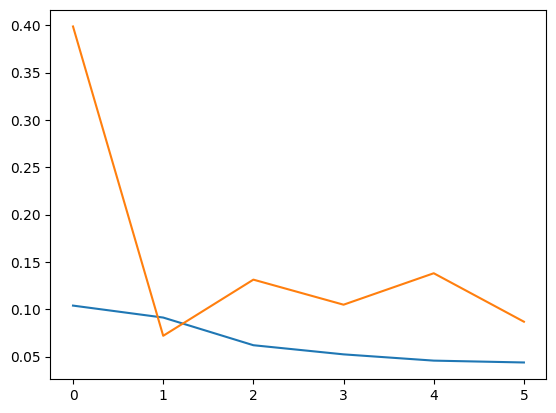

In [75]:
# plot and see the accuracy and loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

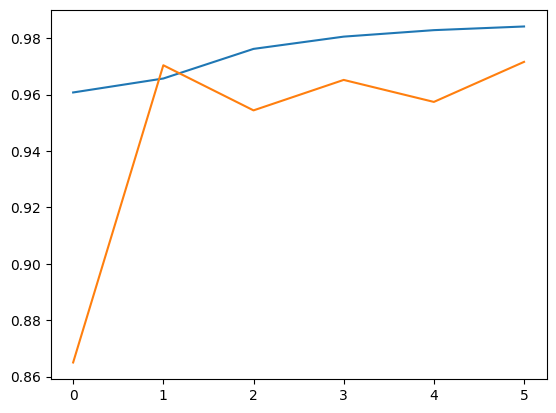

In [76]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

<Axes: >

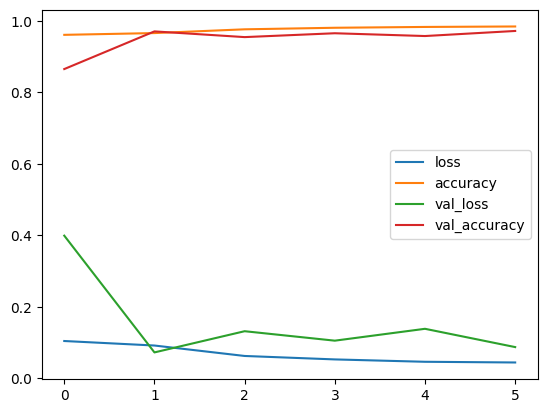

In [77]:
pd.DataFrame(history.history).plot()

In [184]:
cat = cv2.imread("/content/OIP (4).jpeg")

In [185]:
cat.shape

(711, 474, 3)

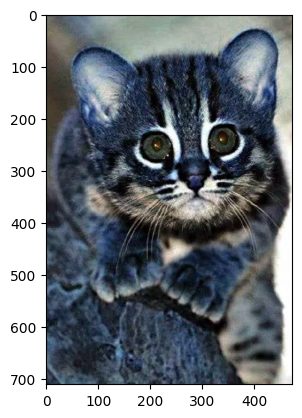

In [186]:
plt.imshow(cat)

In [187]:
test_image = cv2.resize(cat,(256,256))

In [188]:
test_input = test_image.reshape((1,256,256,3))

In [189]:
pred = model.predict(test_input)

1/1 [==============================] - 0s 37ms/step


In [190]:
if pred == 0:
  print("Cat")
else:
  print("Dog")

Cat


In [191]:
dog = cv2.imread("/content/10-of-the-rarest-dog-breeds-in-the-world-7.jpg")

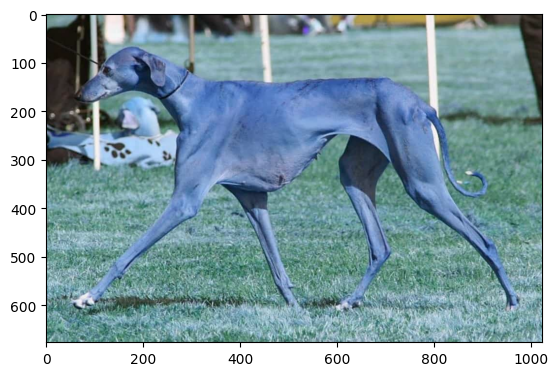

In [192]:
plt.imshow(dog)

In [193]:
test_image = cv2.resize(dog,(256,256))

In [194]:
test_input = test_image.reshape((1,256,256,3))

In [195]:
pred = model.predict(test_input)

1/1 [==============================] - 0s 18ms/step


In [196]:
if pred == 0:
  print("Cat")
else:
  print("Dog")

Dog
